# Andres Graterol - 4031393 - Fall 22
# Homework 3 Question 2 

## Generate The Data

In [19]:
# Import our libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [128]:
# Set up a gaussian prior
a = 1/2
m0 = np.transpose(np.zeros(2))
print("Shape of m0:", m0.shape)
print("m0", m0)

s0 = a*np.identity(2)
print("Shape of s0:", s0.shape)
print("s0", s0)

# Does this need to be of length n?
# Does this need to be done in the form of a multivariate gaussian?
#prior = np.random.normal(m0, s0)
prior = multivariate_normal(mean=m0, cov=s0)
print("prior:", prior)

Shape of m0: (2,)
m0 [0. 0.]
Shape of s0: (2, 2)
s0 [[0.5 0. ]
 [0.  0.5]]
prior: <scipy.stats._multivariate.multivariate_normal_frozen object at 0x0000026F8C005A60>


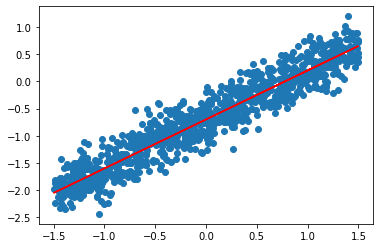

In [66]:
# Variables
N = 1000
variance = 0.25

# Intercept
w0 = -0.7
# slope
w1 = 0.9

# Generating N data points uniform in the interval [-3/2, 3/2]
data_points = np.random.uniform(low = (-3/2), high = (3/2), size = (N,))

noise = np.random.normal(0, variance, len(data_points))

linear_model = w0 + w1*data_points

targets = linear_model + noise
#print(len(targets))

plt.plot(data_points, linear_model, 'red')
plt.scatter(data_points, targets)

## Posterior Update

In [119]:
# Function to compute the design matrix
def compute_design_matrix(input_data):
    matrix = []
    for x in input_data:
        matrix.append([0, x])
    
    #print("Check data", input_data)
    matrix = np.array(matrix)
    #print("Shape of matrix:", matrix.shape)   
    #print(matrix)
    
    return matrix

(1000, 2)
Sn shape: (2, 2)
Mn shape: (2,)


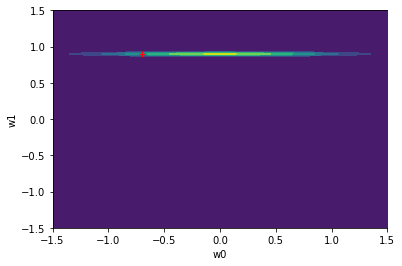

In [129]:
# Plot the posterior of the parameters given all the data x, t
# Obtain the design matrix 
phi = compute_design_matrix(data_points)
print(phi.shape)

Sn = np.linalg.inv(np.linalg.inv(s0) + (1/variance)*(np.matmul(np.transpose(phi), phi)))


Mn = np.matmul(Sn, (np.matmul(np.linalg.inv(s0), m0) + (1/variance)*np.matmul(np.transpose(phi), targets)))
print("Sn shape:", Sn.shape)
print("Mn shape:", Mn.shape)

total_posterior = multivariate_normal(mean=Mn, cov=Sn)

X = np.linspace(-3/2, 3/2, N)
Y = np.linspace(-3/2, 3/2, N)
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))

Z = total_posterior.pdf(pos)

plt.xlabel("w0")
plt.ylabel("w1")
plt.plot(w0, w1, 'r+')
plt.contourf(X, Y, Z)
plt.show()

samples: [array([-0.35416766, -0.68737527]), array([-0.16736801, -0.09286575]), array([-0.30811371,  0.22943929]), array([-1.79196272,  1.13032677]), array([-0.87826121,  0.58237805]), array([-0.59983365, -1.02883356])]


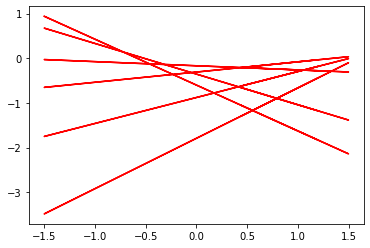

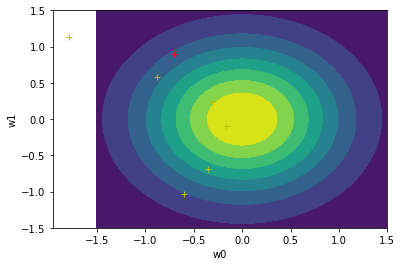

In [130]:
# Plot the assumed multivariate gaussian prior
#X = np.linspace(-3/2, 3/2, N)
#Y = np.linspace(-3/2, 3/2, N)
#X, Y = np.meshgrid(X, Y)
#pos = np.dstack((X, Y))
Z = prior.pdf(pos)

# TODO: Possibly make these deterministic 
# Pick 6 realizations from the prior
# We will pick one to compute the likelihood for 
samples_list = []

for i in range(6):
    samples = prior.rvs()
    samples_list.append(samples)
    
print("samples:", samples_list)

for s in samples_list:
    line = s[0] + s[1]*data_points
    plt.plot(data_points, line, 'red')

plt.show()    

plt.xlabel("w0")
plt.ylabel("w1")
plt.plot(w0, w1, 'r+')
for s in samples_list:
    plt.plot(s[0], s[1], 'y+')
plt.contourf(X, Y, Z)
plt.show()
# Method to update the posterior distribution 
# given a dataset and the prior